# Mineração de Dados: Classificação

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:

O objetivo deste trabalho é criar classificadores que buscam prever a aprovação (ou reprovação) de discentes que participaram de um curso online.
Essas bases de dados apresentam características de pessoas que participaram do curso online "Prevenção do uso de drogas".


Os dados estão disponíveis na pasta do drive compartilhada aqui e são formados por 3 arquivos:
"trabalho5_dados_sociais_ID.csv" - dados sócio-econômicos e de perguntas iniciais respondidas pelos participantes,
"trabalho5_dados_modulo1_ID.csv" - dados de acesso ao sistema de ensino durante as atividades referentes ao primeiro módulo do curso, e
"trabalho5_dados_ateh_modulo2_ID.csv" - dados de acesso ao sistema de ensino para as atividades até o segundo módulo do curso.


Nesse trabalho geramos um modelo para cada um das 3 situações a seguir:
1) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais;
2) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais, e de acesso considerando o primeiro módulo do curso; e
3) um modelo que considera todos os dados disponíveis.

Para cada uma das 3 situações apresentadas, deve-se gerar ao menos 2 modelos de tipos distintos.

**Com a importância de analisar os parâmetros que fornecemos para os modelos**

In [2]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pyclustertend
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale


from mpl_toolkits.mplot3d import Axes3D

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import pygraphviz as pgv
from PIL import Image

from datetime import datetime

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

from time import process_time

#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.set_printoptions(precision=2)
#from sklearn.utils.multiclass import unique_labels

## Leitura dos dados e Tratamento dos dados
---

Primeiro, carregaremos os dados e analisaremos as características sócio-econômicas, perguntas e dados do sistem de ensino providos a partir da base de dados.


### Conjunto de dados

Primeiramente, vamos carregar as bases de dados e separar os rótulos que serão preditos.


In [3]:
# # Características sociais e dos módulos
# df_sociais = pd.read_csv('data/trabalho5_dados_sociais_4.csv')
# df_modulo1 = pd.read_csv('data/trabalho5_dados_modulo1_4.csv')
# df_modulo2 = pd.read_csv('data/trabalho5_dados_ateh_modulo2_4.csv')

# # Rótulos
# y = LabelEncoder().fit(["Sim", "Não"]).transform(df_modulo2["aprovado"])


# df_sociais = df_sociais.drop(["aprovado"], axis=1)
# df_modulo1 = df_modulo1.drop(["aprovado"], axis=1)
# df_modulo2 = df_modulo2.drop(["aprovado"], axis=1)

In [4]:
df_sociais = pd.read_csv('data/trabalho5_dados_sociais_4.csv')
df_sociais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 80 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   id                                                                              1000 non-null   int64 
 1   idade                                                                           1000 non-null   int64 
 2   sexo                                                                            1000 non-null   object
 3   escolaridade                                                                    1000 non-null   object
 4   estadocivil                                                                     1000 non-null   object
 5   ocupacao                                                                        1000 non-null   object
 6   tempodeservico           

In [5]:
df_sociais.columns

Index(['id', 'idade', 'sexo', 'escolaridade', 'estadocivil', 'ocupacao',
       'tempodeservico', 'religiao', 'contatoanterior', 'lidadiretamente',
       'lida.onde', 'materialdidatico', 'prazoatividades', 'interacaopares',
       'organizacaocurso', 'import.ajud.tutor', 'autoavaliacao.x',
       'part.outrocurso', 'pp001', 'pp002', 'pp003', 'pp004', 'pp005', 'pp006',
       'pp007', 'pp008', 'pp009', 'pp010', 'pp011', 'pp012', 'pp013', 'pp014',
       'pp015', 'pp016', 'pp017', 'pp018', 'pp019', 'pp020', 'pp021', 'pp022',
       'pp023', 'pp024', 'pp025', 'pp026', 'pp027', 'pp028', 'pp029', 'pp030',
       'pp031', 'pp032', 'pp033', 'pp034', 'pp035', 'pp036', 'pp037',
       'aprovado', 'Identificação pessoal com o tema (motivopart)',
       'Identificação profissional com o tema (motivopart)',
       'Para aquisição de conhecimento na área (motivopart)',
       'Pelo fato de o curso ser gratuito (motivopart)',
       'Pelo fato de o curso estar vinculado à Universidade (motivopart)'

In [6]:
df_sociais

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,...,Ausência de regras no ambiente escolar (barreiras),Possuir alunos interessados na temática (facilitadores),Presença de uma equipe para trabalhar a temática (facilitadores),Estímulo aos alunos (facilitadores),Desenvolvimento de projetos na escola (facilitadores),Apoio aos projetos em desenvolvimento (facilitadores),Presença de regras no ambiente escolar (facilitadores),Promoção de compromisso e confiança (facilitadores),Valorização do ambiente escolar (facilitadores),Participação da comunidade e dos pais no trabalho de prevenção (facilitadores)
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,Sim,Sim,...,0,1,1,1,1,0,0,1,1,1
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,Não,Sim,...,1,1,1,1,1,1,1,1,1,1
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,Sim,Sim,...,0,1,0,0,0,0,0,0,1,1
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,Não,Não,...,0,0,0,0,0,0,0,0,0,0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,Sim,Sim,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,Sim,Sim,...,0,0,0,0,0,0,0,0,0,0
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,Sim,Sim,...,0,1,1,0,1,1,0,1,1,0
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,Sim,Não,...,0,0,0,0,0,0,0,0,0,0
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,Não,Sim,...,0,1,1,0,1,1,0,0,0,1


#### Tratamento da coluna de target
---

In [7]:
# Trata coluna target
df_sociais = df_sociais.replace('Sim', 1).replace('Não', 0)
df_sociais.aprovado = df_sociais.aprovado.astype(bool)

In [8]:
df_sociais.aprovado.unique()

array([ True, False])

In [9]:
df_sociais.iloc[:,0:18]

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,lida.onde,materialdidatico,prazoatividades,interacaopares,organizacaocurso,import.ajud.tutor,autoavaliacao.x,part.outrocurso
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,1,1,Escola,Adequado,Flexível,Importante,Organizado,Sempre,"Sim, considero, porém, poderia estar me esforç...",1
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,0,1,Escola,Muito adequado,Flexível,Importante,Muito organizado,Sempre,"Sim, considero, porém, poderia estar me esforç...",0
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,1,1,Escola,Muito adequado,Muito flexível,Importante,Muito organizado,Sempre,"Sim, considero",1
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,0,0,Escola,Adequado,Flexível,Importante,Organizado,Sempre,"Sim, considero, porém, poderia estar me esforç...",0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,1,1,Amigos,Adequado,Pouco flexível,Importante,Organizado,Sempre,"Sim, considero, porém, poderia estar me esforç...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,1,1,Escola,Adequado,Flexível,Importante,Organizado,Às vezes,"Sim, considero",0
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,1,1,Escola,Muito adequado,Flexível,Importante,Muito organizado,Sempre,"Sim, considero",0
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,1,0,Família,Adequado,Flexível,Importante,Organizado,Sempre,"Sim, considero",1
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,0,1,Comunidade,Muito adequado,Flexível,Muito importante,Organizado,Sempre,"Sim, considero, porém, poderia estar me esforç...",0


In [10]:
print(df_sociais.materialdidatico.unique())

df_sociais.materialdidatico = df_sociais.materialdidatico.replace({'Adequado': 1, 'Muito adequado': 2})

print(df_sociais.materialdidatico.unique())

['Adequado' 'Muito adequado']
[1 2]


In [11]:
print(df_sociais.prazoatividades.unique())

df_sociais.prazoatividades = df_sociais.prazoatividades.replace({'Pouquíssimo flexível': 1, 'Pouco flexível': 2, 'Flexível': 3, 'Muito flexível': 4})

print(df_sociais.prazoatividades.unique())

['Flexível' 'Muito flexível' 'Pouco flexível' 'Pouquíssimo flexível']
[3 4 2 1]


In [12]:
print(df_sociais.interacaopares.unique())

df_sociais.interacaopares = df_sociais.interacaopares.replace({'Importante': 1, 'Muito importante': 2})

print(df_sociais.interacaopares.unique())

['Importante' 'Muito importante']
[1 2]


In [13]:
print(df_sociais.organizacaocurso.unique())

df_sociais.organizacaocurso = df_sociais.organizacaocurso.replace({'Organizado': 1, 'Muito organizado': 2})

print(df_sociais.organizacaocurso.unique())

['Organizado' 'Muito organizado']
[1 2]


In [14]:
print(df_sociais['import.ajud.tutor'].unique())

df_sociais['import.ajud.tutor'] = df_sociais['import.ajud.tutor'].replace({'Às vezes': 1, 'Sempre': 2})

print(df_sociais['import.ajud.tutor'].unique())

['Sempre' 'Às vezes']
[2 1]


In [15]:
print(df_sociais['autoavaliacao.x'].unique())

df_sociais['autoavaliacao.x'] = df_sociais['autoavaliacao.x'].replace({'Não, não considero': 1, 'Sim, considero, porém, poderia estar me esforçando mais': 2, 'Sim, considero': 3})

print(df_sociais['autoavaliacao.x'].unique())


['Sim, considero, porém, poderia estar me esforçando mais'
 'Sim, considero' 'Não, não considero']
[2 3 1]


In [16]:
df_sociais.iloc[:,0:18]

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,lida.onde,materialdidatico,prazoatividades,interacaopares,organizacaocurso,import.ajud.tutor,autoavaliacao.x,part.outrocurso
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,1,1,Escola,1,3,1,1,2,2,1
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,0,1,Escola,2,3,1,2,2,2,0
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,1,1,Escola,2,4,1,2,2,3,1
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,0,0,Escola,1,3,1,1,2,2,0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,1,1,Amigos,1,2,1,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,1,1,Escola,1,3,1,1,1,3,0
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,1,1,Escola,2,3,1,2,2,3,0
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,1,0,Família,1,3,1,1,2,3,1
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,0,1,Comunidade,2,3,2,1,2,2,0


In [17]:
pd.unique(df_sociais.iloc[:, 18:55].values.ravel('K'))

array(['Discordo', 'Discordo totalmente', 'Concordo totalmente',
       'Nem discordo, nem concordo', 'Concordo'], dtype=object)

In [18]:
df_sociais = df_sociais.replace({'Discordo totalmente': 1, 'Discordo': 2, 'Nem discordo, nem concordo': 3, 'Concordo': 4, 'Concordo totalmente': 5})

In [19]:
df_sociais['lida.onde']

0          Escola
1          Escola
2          Escola
3          Escola
4          Amigos
          ...    
995        Escola
996        Escola
997       Família
998    Comunidade
999        Escola
Name: lida.onde, Length: 1000, dtype: object

Não existe campos nulos

In [20]:
df_sociais.isna().sum().sum()

0

#### Substituição das variáveis qualitativas

- O que é "Sim" para 1 e do que é "Não" para 0

In [21]:
df_sociais = df_sociais.replace('Sim', True).replace('Não', False)

In [22]:
df_sociais

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,...,Ausência de regras no ambiente escolar (barreiras),Possuir alunos interessados na temática (facilitadores),Presença de uma equipe para trabalhar a temática (facilitadores),Estímulo aos alunos (facilitadores),Desenvolvimento de projetos na escola (facilitadores),Apoio aos projetos em desenvolvimento (facilitadores),Presença de regras no ambiente escolar (facilitadores),Promoção de compromisso e confiança (facilitadores),Valorização do ambiente escolar (facilitadores),Participação da comunidade e dos pais no trabalho de prevenção (facilitadores)
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,1,1,...,0,1,1,1,1,0,0,1,1,1
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,0,1,...,1,1,1,1,1,1,1,1,1,1
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,1,1,...,0,1,0,0,0,0,0,0,1,1
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,0,0,...,0,0,0,0,0,0,0,0,0,0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,1,1,...,0,0,0,0,0,0,0,0,0,0
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,1,1,...,0,1,1,0,1,1,0,1,1,0
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,1,0,...,0,0,0,0,0,0,0,0,0,0
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,0,1,...,0,1,1,0,1,1,0,0,0,1


### Pega códigos das categorias em tipo númerico por meio do cat.codes
---

In [65]:
df_sociais[df_sociais.select_dtypes('object').columns] = df_sociais.select_dtypes('object').astype('category').apply(lambda x: x.cat.codes)

In [64]:
df_sociais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 80 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   id                                                                              1000 non-null   int64 
 1   idade                                                                           1000 non-null   int64 
 2   sexo                                                                            1000 non-null   object
 3   escolaridade                                                                    1000 non-null   object
 4   estadocivil                                                                     1000 non-null   object
 5   ocupacao                                                                        1000 non-null   object
 6   tempodeservico           

### Parte dos datasets dos módulos

In [25]:
df_modulo1 = pd.read_csv("data/trabalho5_dados_modulo1_4.csv").drop(columns='aprovado')
df_modulo1.info()

# não existe dados nulos, todas linhas de todas as colunas estão preenchidas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          1000 non-null   int64
 1   quesm1      1000 non-null   int64
 2   quesm1r     1000 non-null   int64
 3   forum1      1000 non-null   int64
 4   forum2      1000 non-null   int64
 5   forum3      1000 non-null   int64
 6   forum4      1000 non-null   int64
 7   ativcolm1   1000 non-null   int64
 8   ativcolm1r  1000 non-null   int64
 9   forum1r     1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB


In [26]:
df_modulo1

,id,quesm1,quesm1r,forum1,forum2,forum3,forum4,ativcolm1,ativcolm1r,forum1r
0,7,1,0,1,0,1,1,1,0,0
1,33,1,0,1,1,1,1,1,0,1
2,45,1,0,1,1,1,1,1,0,0
3,50,1,0,0,0,1,0,1,0,0
4,58,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,10859,1,1,1,1,1,1,1,1,1
996,10872,0,1,1,0,0,0,1,0,1
997,10873,1,1,0,1,1,1,1,0,1
998,10876,1,1,1,1,1,1,1,0,1


In [27]:
df_modulo1 = df_modulo1.replace('Sim', 1).replace('Não', 0)

In [28]:
df_modulo2 = pd.read_csv("data/trabalho5_dados_ateh_modulo2_4.csv").drop(columns='aprovado')
df_modulo2.info()

# não existe dados nulos, todas linhas de todas as colunas estão preenchidas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          1000 non-null   int64
 1   quesm2      1000 non-null   int64
 2   ativcolm2   1000 non-null   int64
 3   forum5      1000 non-null   int64
 4   forum6      1000 non-null   int64
 5   forum7      1000 non-null   int64
 6   ativcolm2r  1000 non-null   int64
 7   quesm2r     1000 non-null   int64
 8   forum8      1000 non-null   int64
 9   forum2r     1000 non-null   int64
 10  quesm1      1000 non-null   int64
 11  quesm1r     1000 non-null   int64
 12  forum1      1000 non-null   int64
 13  forum2      1000 non-null   int64
 14  forum3      1000 non-null   int64
 15  forum4      1000 non-null   int64
 16  ativcolm1   1000 non-null   int64
 17  ativcolm1r  1000 non-null   int64
 18  forum1r     1000 non-null   int64
dtypes: int64(19)
memory usage: 148.6 KB


In [29]:
df_modulo2

,id,quesm2,ativcolm2,forum5,forum6,forum7,ativcolm2r,quesm2r,forum8,forum2r,quesm1,quesm1r,forum1,forum2,forum3,forum4,ativcolm1,ativcolm1r,forum1r
0,7,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,0,0
1,33,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,1
2,45,1,1,1,0,1,0,0,1,0,1,0,1,1,1,1,1,0,0
3,50,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1
996,10872,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1
997,10873,1,1,0,1,0,0,0,0,1,1,1,0,1,1,1,1,0,1
998,10876,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,1


In [30]:
df_modulo2 = df_modulo2.replace('Sim', 1).replace('Não', 0)

# Análises exploratórias e entendimento dos dados

- Distribuição das pessoas em  suas características a respeito do curso
- Quantidade de aprovados e não aprovados
- Quantidade de alunos que não iam nas aulas ou não faziam as atividades



Todo essas análise corrobora para a escolha certa de parâmetros e ajuda no entendimento das classficações que serão feitas abaixo

In [31]:
#plt.bar(df_sociais.aprovado)

<AxesSubplot:xlabel='aprovado'>

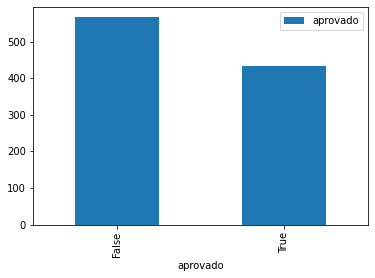

In [32]:
df_sociais.groupby('aprovado').agg({'aprovado': 'count'}).plot.bar()

### Funções
---

In [72]:
def decisionTree(df, xList, yList, saveFileName='decisionTree', insideDTreeBalancing=False):
    X = df[xList].drop(columns=yList) #.iloc[:,[8,9,10,12,13]]
    y = df[yList] #.iloc[:,7].values.ravel()


    if(insideDTreeBalancing):
        modelo = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 8, min_impurity_decrease=0.01, class_weight='balanced')# min_samples_split = 0.2
    else:
        modelo = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 8, min_impurity_decrease=0.01)
    # criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 8, min_impurity_decrease=0.01
    # max_leaf_nodes = 10
    # min_samples_leaf = 5
    # min_samples_split
    # max_depth = None
    # min_impurity_decrease=0.005
    modelo.fit(X,y) # 12 -> approved


    decisionTreeToGraph(modelo, X.columns, ['não aprovado', 'aprovado'], saveFileName)

    return modelo

In [34]:
def decisionTreeToGraph(modelDt, columns, class_names, saveFileName):
    expModelo = tree.export_graphviz(modelDt, out_file=None, feature_names=columns, class_names=class_names, filled=True, rounded=True, special_characters=True) 
    grafo = pgv.AGraph(expModelo)



    details = open('details_parameters.txt','a')
    details.write(saveFileName + '\n')
    details.write(str(modelDt.get_params(deep=False)) + '\n\n')
    details.close()
    
    formatImg = 'png' # eps
    saveFileName += '.' + formatImg
    grafo.draw(saveFileName, formatImg, 'dot')

    display(Image.open(saveFileName))
    # imprime o modelo da arvore
    #printDecisions(modelo, X.columns, ['unconfirmed', 'confirmed'])

In [35]:
def make_confusion_matrix(df, nameOfPlot):
    X = df[['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']]
    y = df['receipt_status']


    #df.reset_index(drop=True)
    #print(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    print('X_treino:', len(X_train), round(len(X_train)/len(X), 2))
    print('X_teste:', len(X_test), round(len(X_test)/len(X),2))
    print('y_treino:', len(y_train), round(len(y_train)/len(y),2))
    print('y_teste:', len(y_test), round(len(y_test)/len(y),2))

    model = tree.DecisionTreeClassifier(class_weight='balanced')
    model.fit(X_train, y_train)

    y_predict = model.predict(X_test)

    model_acuracy_score = accuracy_score(y_test, y_predict)

    result_confusion_matrix = pd.DataFrame(
        confusion_matrix(y_test, y_predict),
        columns=['Predicted Unconfirmed', 'Predicted Confirmed'],
        index=['True Unconfirmed', 'True Confirmed']
    )


    # Impressão do gráfico da Matriz de Confusão
    #class_names = np.asarray(['unconfirmed', 'confirmed'])
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=['unconfirmed', 'confirmed'], title=nameOfPlot)
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=['unconfirmed', 'confirmed'], normalize=True, title= (nameOfPlot + ' Normalized'))
    plt.show()



    #print(model_acuracy_score, '\n')
    #print(result_confusion_matrix)
    return model_acuracy_score, result_confusion_matrix

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ''' -----> Print solution of confusion matrix in letters
    #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    print(cm)
    '''

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




## Situação 1 - Características sócio-econômicas e perguntas iniciais

### Pega códigos das categorias em tipo númerico por meio do cat.codes
---

In [ ]:
df_sociais[df_sociais.select_dtypes('object').columns] = df_sociais.select_dtypes('object').astype('category').apply(lambda x: x.cat.codes)

In [78]:
featuresColumns = df_sociais.columns  # 19:55 .iloc[:, 11:17].columns #df_sociais.drop(columns=['aprovado']).columns
targetColumn = ['aprovado']

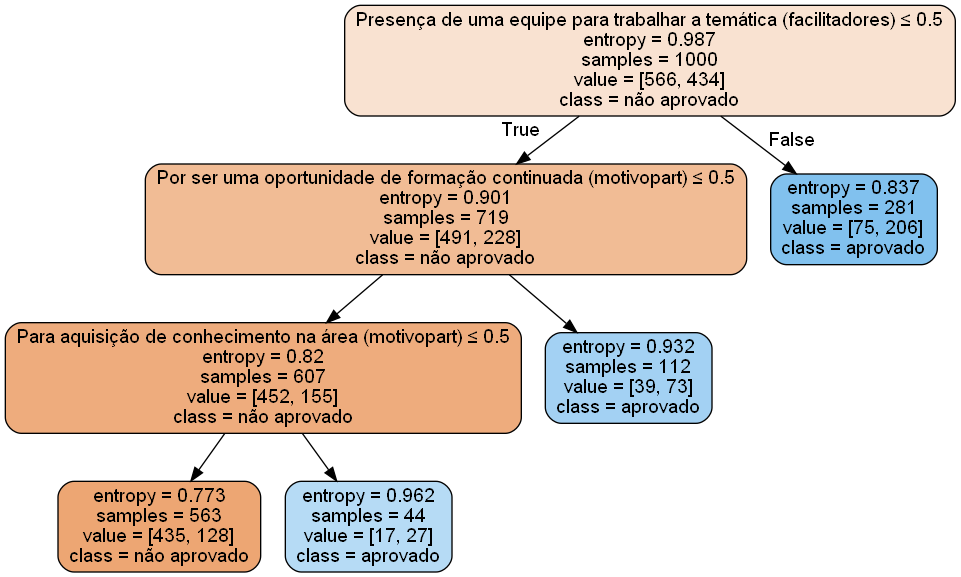

In [79]:
model = decisionTree(df_sociais, xList=featuresColumns, yList=targetColumn, saveFileName='df_class_weight_balanced', insideDTreeBalancing=False)

In [69]:
model.score(df_sociais, df_sociais['aprovado'])

ValueError: X has 80 features, but DecisionTreeClassifier is expecting 72 features as input.

# Situação 2 - Características sócio-econômicas, perguntas iniciais e primeiro módulo do curso

In [218]:
df_situcao2 = pd.merge(df_sociais, df_modulo1, on='id', how='inner')

In [87]:
df_situcao2

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,...,Participação da comunidade e dos pais no trabalho de prevenção (facilitadores),quesm1,quesm1r,forum1,forum2,forum3,forum4,ativcolm1,ativcolm1r,forum1r
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,1,1,...,1,1,0,1,0,1,1,1,0,0
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,0,1,...,1,1,0,1,1,1,1,1,0,1
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,1,1,...,1,1,0,1,1,1,1,1,0,0
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,0,0,...,0,1,0,0,0,1,0,1,0,0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,1,1,...,0,1,1,1,1,1,1,1,1,1
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,1,1,...,0,0,1,1,0,0,0,1,0,1
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,1,0,...,0,1,1,0,1,1,1,1,0,1
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,0,1,...,1,1,1,1,1,1,1,1,0,1


# Situação 2 - Características sócio-econômicas, perguntas iniciais, primeiro e segundo módulo do curso (todos os dados)

In [84]:
df_situcao3 = pd.merge(df_situcao2, df_modulo2, on='id', how='inner', suffixes=('_mod1', '_mod2'))

In [85]:
df_situcao3

,id,idade,sexo,escolaridade,estadocivil,ocupacao,tempodeservico,religiao,contatoanterior,lidadiretamente,...,forum2r,quesm1_mod2,quesm1r_mod2,forum1_mod2,forum2_mod2,forum3_mod2,forum4_mod2,ativcolm1_mod2,ativcolm1r_mod2,forum1r_mod2
0,7,45,Feminino,Pós-graduação,Casado (a),Professor (a),22,Católica,1,1,...,0,1,0,1,0,1,1,1,0,0
1,33,49,Masculino,Pós-graduação,Casado (a),Outros,29,Católica,0,1,...,1,1,0,1,1,1,1,1,0,1
2,45,49,Feminino,Pós-graduação,Divorciado (a),Professor (a),19,Católica,1,1,...,0,1,0,1,1,1,1,1,0,0
3,50,55,Masculino,Pós-graduação,Casado (a),Professor (a),29,Católica,0,0,...,0,1,0,0,0,1,0,1,0,0
4,58,49,Masculino,Ensino Superior Completo,Casado (a),Professor (a),10,Católica,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10859,47,Feminino,Pós-graduação,Casado (a),Professor (a),25,Católica,1,1,...,1,1,1,1,1,1,1,1,1,1
996,10872,42,Feminino,Pós-graduação,Casado (a),Professor (a),20,Católica,1,1,...,0,0,1,1,0,0,0,1,0,1
997,10873,46,Feminino,Ensino Superior Completo,Casado (a),Professor (a),4,Católica,1,0,...,1,1,1,0,1,1,1,1,0,1
998,10876,48,Feminino,Pós-graduação,Casado (a),Professor (a),16,Católica,0,1,...,0,1,1,1,1,1,1,1,0,1
